# Importing the Main Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reading the merged CSV Data Set

In [26]:
df = pd.read_csv(r"C:\Users\vishw\Desktop\CAPSTONE\merged_data.csv")

In [27]:
df.head()

,date,Open,High,Low,Close,Adj Close,Volume,Return,Volatility,CPI,ZEW_Sentiment,ZEW_Situation,Bond_Yield,EURUSD,Unemployment,GDP
0,2020-01-01,13233.71,13640.06,12948.17,12981.97,12981.97,1.737147e+09,NaN,NaN,105.2175,26.7,-9.5,-0.313636,1.1098,3.2,-1.91095
1,2020-02-01,13033.17,13795.24,11724.12,11890.35,11890.35,2.231748e+09,-0.087834,NaN,105.5338,8.7,-15.7,-0.466000,1.0911,3.3,-1.91095
2,2020-03-01,12030.27,12272.99,8255.65,9935.84,9935.84,4.826748e+09,-0.179579,NaN,105.7447,-49.5,-43.1,-0.541364,1.1046,3.4,-1.91095
3,2020-04-01,9610.67,11235.57,9337.02,10861.64,10861.64,2.507300e+09,0.089089,NaN,105.8501,28.2,-91.5,-0.449500,1.0871,3.5,-10.69804
4,2020-05-01,10543.36,11813.14,10160.89,11586.85,11586.85,2.221914e+09,0.064634,NaN,105.8501,51.0,-93.5,-0.516500,1.0907,3.6,-10.69804


We want to forecast DAX Volatility.
Think of volatility as “market nervousness.” If you can predict it → investors know when markets may be risky, policymakers can prepare.

Why check stationarity first?

Stationarity means: the series has a stable mean, variance, and autocorrelation over time.

Most time-series models (ARIMA, GARCH, etc.) require stationarity, otherwise predictions go haywire.

Example: If volatility keeps trending up → model may think it will go to infinity 🤦‍♂️. Differencing/logs fix that.

Our game plan now:

Step 1: Run ADF Test (Augmented Dickey-Fuller) → tells us if volatility is stationary.

Step 2: If not → transform (log or difference).

Step 3: Fit ARIMA baseline → quick benchmark forecast.

Step 4: Later → do Holt-Winters (trend/seasonality) and GARCH (volatility clustering).

ADF Statistic: -2.2768478161356525
p-value: 0.17954375828388902
Critical Value 1%: -3.6699197407407405
Critical Value 5%: -2.9640707407407407
Critical Value 10%: -2.621171111111111
❌ The series is NOT stationary. Consider differencing or log transform.


C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

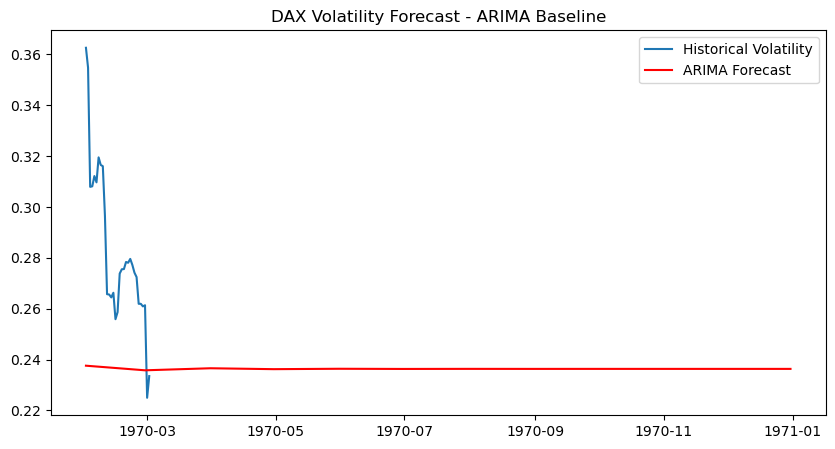

In [28]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Assuming your final merged dataset is called df
# and you already have 'Volatility' column
volatility = df['Volatility'].dropna()

# -----------------
# 1. Stationarity Check (ADF Test)
# -----------------
adf_result = adfuller(volatility)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

if adf_result[1] < 0.05:
    print("✅ The series is stationary.")
else:
    print("❌ The series is NOT stationary. Consider differencing or log transform.")

# -----------------
# 2. ARIMA Baseline Forecast
# -----------------
# Let's try ARIMA(1,1,1) as a start (we can tune later)
model = ARIMA(volatility, order=(1,1,1))
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)

# Plot
plt.figure(figsize=(10,5))
plt.plot(volatility, label="Historical Volatility")
plt.plot(pd.date_range(start=volatility.index[-1], periods=12, freq="M"), forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("DAX Volatility Forecast - ARIMA Baseline")
plt.show()


In [29]:

vol_diff = volatility.diff().dropna()

# ADF Test again
adf_result_diff = adfuller(vol_diff)
print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])

if adf_result_diff[1] < 0.05:
    print("✅ Now the series is stationary.")
else:
    print("❌ Still not stationary, may need further differencing or transformation.")


ADF Statistic (Differenced): -5.060928909539174
p-value: 1.6789638560246626e-05
✅ Now the series is stationary.


In [30]:
pip install arch


Note: you may need to restart the kernel to use updated packages.


In [31]:
# ARIMA, Holt-Winters
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# GARCH
from arch import arch_model

# For metrics
from sklearn.metrics import mean_squared_error

In [32]:
# Assuming 'vol_diff' is your stationary series
train_size = int(len(vol_diff) * 0.85)  # 85% train, 15% test
train = vol_diff[:train_size]
test = vol_diff[train_size:]

print(f"Train length: {len(train)}, Test length: {len(test)}")


Train length: 25, Test length: 5


C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

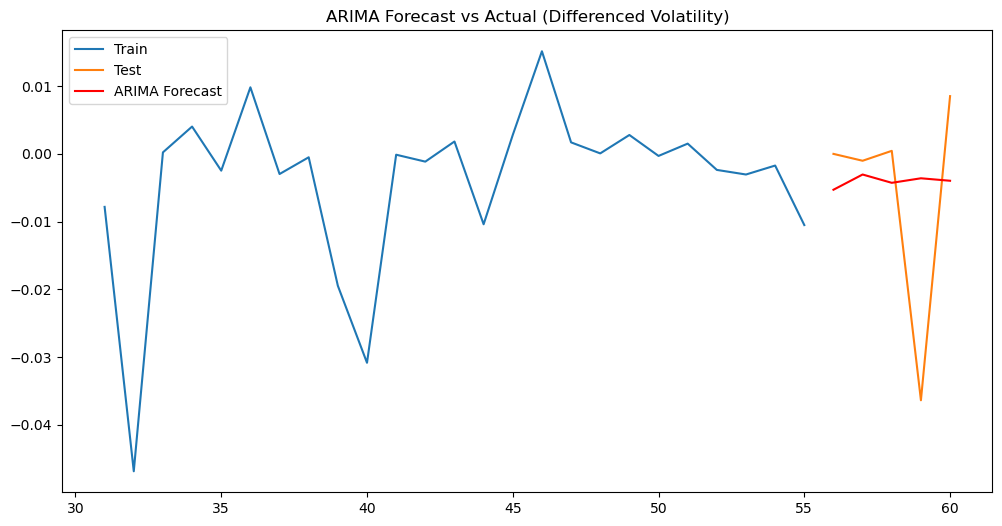

ARIMA RMSE: 0.01603151489178708


In [33]:
from statsmodels.tsa.arima.model import ARIMA

# Example: ARIMA(1,0,1) — p=1, d=0 (already differenced), q=1
arima_model = ARIMA(train, order=(1,0,1))
arima_result = arima_model.fit()

# Forecast for test period
arima_forecast = arima_result.forecast(steps=len(test))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual (Differenced Volatility)')
plt.legend()
plt.show()

# Evaluate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
print("ARIMA RMSE:", rmse_arima)


C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


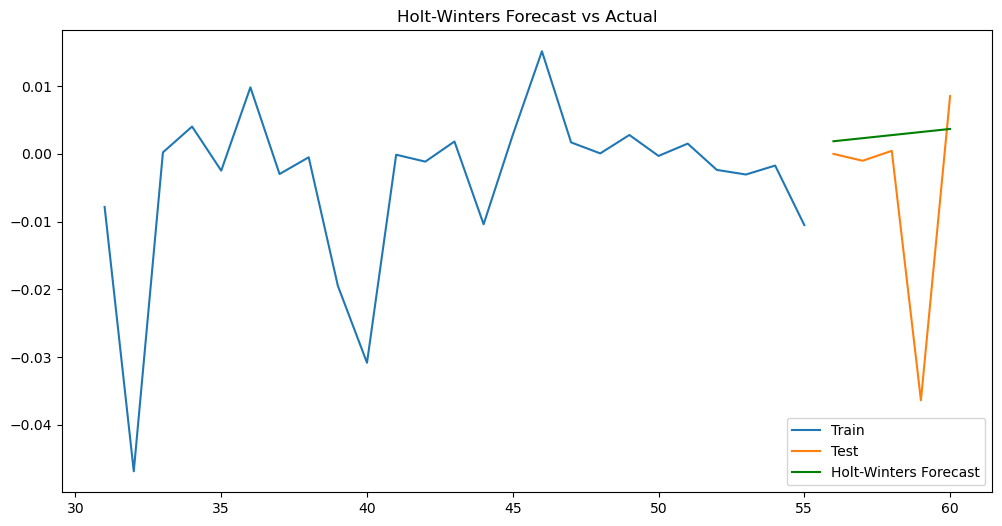

Holt-Winters RMSE: 0.017957132534117428


In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
hw_forecast = hw_model.forecast(len(test))

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='green')
plt.title('Holt-Winters Forecast vs Actual')
plt.legend()
plt.show()

rmse_hw = np.sqrt(mean_squared_error(test, hw_forecast))
print("Holt-Winters RMSE:", rmse_hw)


C:\Users\vishw\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001521. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


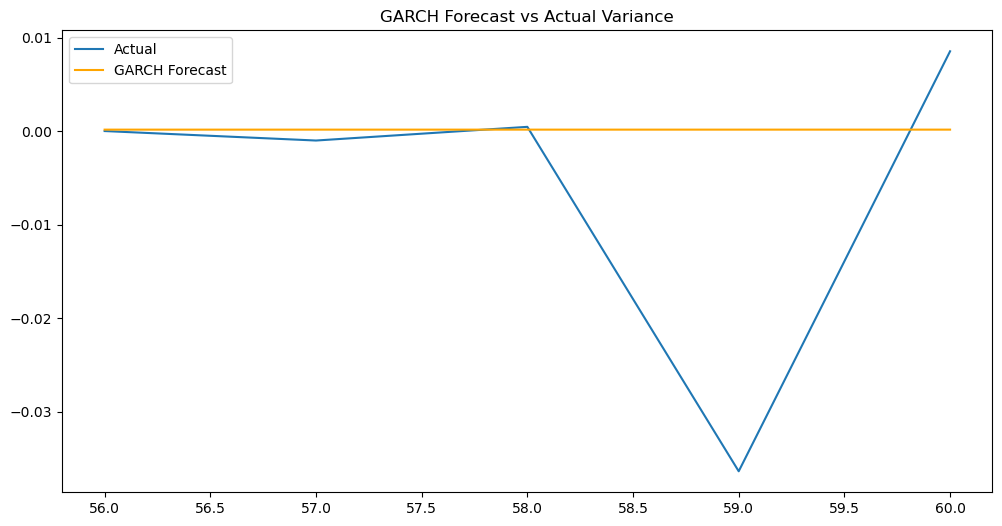

In [35]:
from arch import arch_model

# Fit GARCH(1,1) on differenced volatility
garch_model = arch_model(train, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Forecast variance for test period
garch_forecast = garch_result.forecast(horizon=len(test))
pred_variance = garch_forecast.variance.values[-1, :]

plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, pred_variance, label='GARCH Forecast', color='orange')
plt.title('GARCH Forecast vs Actual Variance')
plt.legend()
plt.show()


In [36]:
print("ARIMA RMSE:", rmse_arima)
print("Holt-Winters RMSE:", rmse_hw)
garch_rmse = np.sqrt(mean_squared_error(test, pred_variance))
print("GARCH RMSE (variance):", garch_rmse)


ARIMA RMSE: 0.01603151489178708
Holt-Winters RMSE: 0.017957132534117428
GARCH RMSE (variance): 0.016770430553881287


In [41]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Volatility,CPI,ZEW_Sentiment,ZEW_Situation,Bond_Yield,EURUSD,Unemployment,GDP
date,,,,,,,,,,,,,,,
2020-01-01,13233.71,13640.06,12948.17,12981.97,12981.97,1.737147e+09,NaN,NaN,105.2175,26.7,-9.5,-0.313636,1.1098,3.2,-1.91095
2020-02-01,13033.17,13795.24,11724.12,11890.35,11890.35,2.231748e+09,-0.087834,NaN,105.5338,8.7,-15.7,-0.466000,1.0911,3.3,-1.91095
2020-03-01,12030.27,12272.99,8255.65,9935.84,9935.84,4.826748e+09,-0.179579,NaN,105.7447,-49.5,-43.1,-0.541364,1.1046,3.4,-1.91095
2020-04-01,9610.67,11235.57,9337.02,10861.64,10861.64,2.507300e+09,0.089089,NaN,105.8501,28.2,-91.5,-0.449500,1.0871,3.5,-10.69804
2020-05-01,10543.36,11813.14,10160.89,11586.85,11586.85,2.221914e+09,0.064634,NaN,105.8501,51.0,-93.5,-0.516500,1.0907,3.6,-10.69804


C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


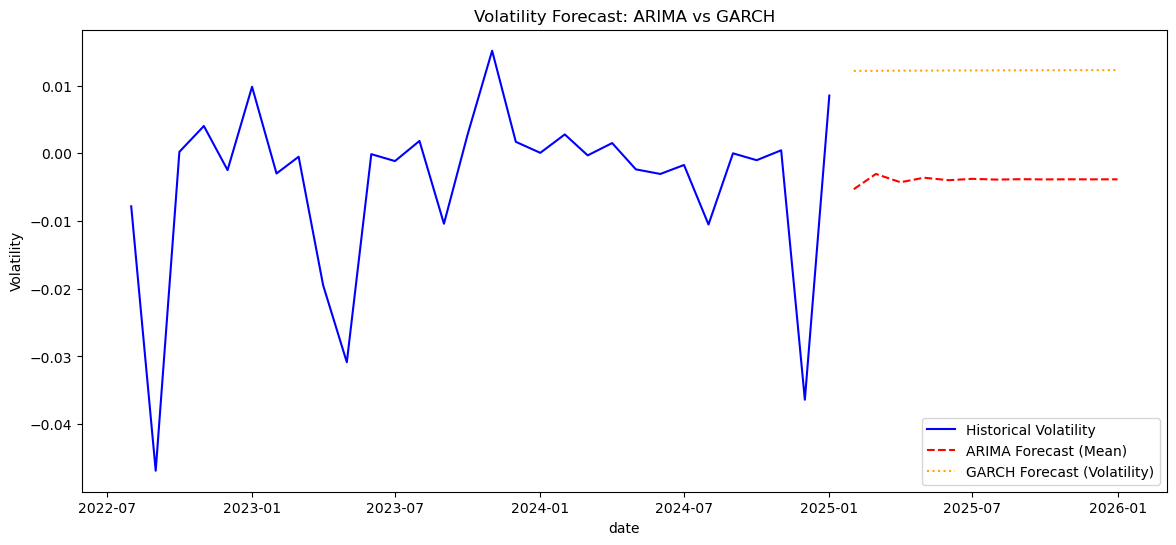

In [42]:

volatility = df['Volatility']
vol_diff = volatility.diff().dropna()  # first difference
# Now vol_diff.index is datetime

# --- Step 1: Forecast next 12 months using ARIMA ---
# arima_result = your fitted ARIMA model from before
arima_forecast_12 = arima_result.forecast(steps=12)

# Create future dates for next 12 months
last_date = vol_diff.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
arima_forecast_12.index = future_dates

# --- Step 2: Forecast next 12 months using GARCH ---
# garch_result = your fitted GARCH model from before
garch_forecast_12 = garch_result.forecast(horizon=12)
garch_variance_12 = garch_forecast_12.variance.values[-1, :]
garch_volatility_12 = np.sqrt(garch_variance_12)
garch_volatility_12 = pd.Series(garch_volatility_12, index=future_dates)

# --- Step 3: Plot historical + forecasts ---
plt.figure(figsize=(14,6))
plt.plot(vol_diff, label='Historical Volatility', color='blue')
plt.plot(arima_forecast_12, label='ARIMA Forecast (Mean)', color='red', linestyle='--')
plt.plot(garch_volatility_12, label='GARCH Forecast (Volatility)', color='orange', linestyle=':')
plt.title('Volatility Forecast: ARIMA vs GARCH')
plt.xlabel('date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [38]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Volatility,CPI,ZEW_Sentiment,ZEW_Situation,Bond_Yield,EURUSD,Unemployment,GDP
date,,,,,,,,,,,,,,,
2020-01-01,13233.71,13640.06,12948.17,12981.97,12981.97,1.737147e+09,NaN,NaN,105.2175,26.7,-9.5,-0.313636,1.1098,3.2,-1.91095
2020-02-01,13033.17,13795.24,11724.12,11890.35,11890.35,2.231748e+09,-0.087834,NaN,105.5338,8.7,-15.7,-0.466000,1.0911,3.3,-1.91095
2020-03-01,12030.27,12272.99,8255.65,9935.84,9935.84,4.826748e+09,-0.179579,NaN,105.7447,-49.5,-43.1,-0.541364,1.1046,3.4,-1.91095
2020-04-01,9610.67,11235.57,9337.02,10861.64,10861.64,2.507300e+09,0.089089,NaN,105.8501,28.2,-91.5,-0.449500,1.0871,3.5,-10.69804
2020-05-01,10543.36,11813.14,10160.89,11586.85,11586.85,2.221914e+09,0.064634,NaN,105.8501,51.0,-93.5,-0.516500,1.0907,3.6,-10.69804


In [39]:
from statsmodels.tsa.arima.model import ARIMA

# Suppose df has columns: 'Volatility', 'CPI', 'Bond_Yield', 'Exchange_Rate'
exog_vars = df[['CPI', 'Bond_Yield', 'EURUSD', 'ZEW_Sentiment', 'Unemployment', 'GDP']]  # predictors
exog_vars = exog_vars.loc[vol_diff.index]  # match index of stationary series

# Fit ARIMA with exogenous variables (using your previous ARIMA orders, e.g., (1,0,1))
arimax_model = ARIMA(vol_diff, order=(1,0,1), exog=exog_vars)
arimax_result = arimax_model.fit()

# Forecast next 12 months
# For forecasting, you need the **future values of exogenous variables** (can use last known value or estimate)
future_exog = exog_vars.tail(1).values.repeat(12, axis=0)  # simple example: repeat last known value
arimax_forecast = arimax_result.forecast(steps=12, exog=future_exog)

print(arimax_forecast)


2025-02-01   -0.010406
2025-03-01   -0.005903
2025-04-01   -0.006533
2025-05-01   -0.006445
2025-06-01   -0.006458
2025-07-01   -0.006456
2025-08-01   -0.006456
2025-09-01   -0.006456
2025-10-01   -0.006456
2025-11-01   -0.006456
2025-12-01   -0.006456
2026-01-01   -0.006456
Freq: MS, Name: predicted_mean, dtype: float64


C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\vishw\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer w

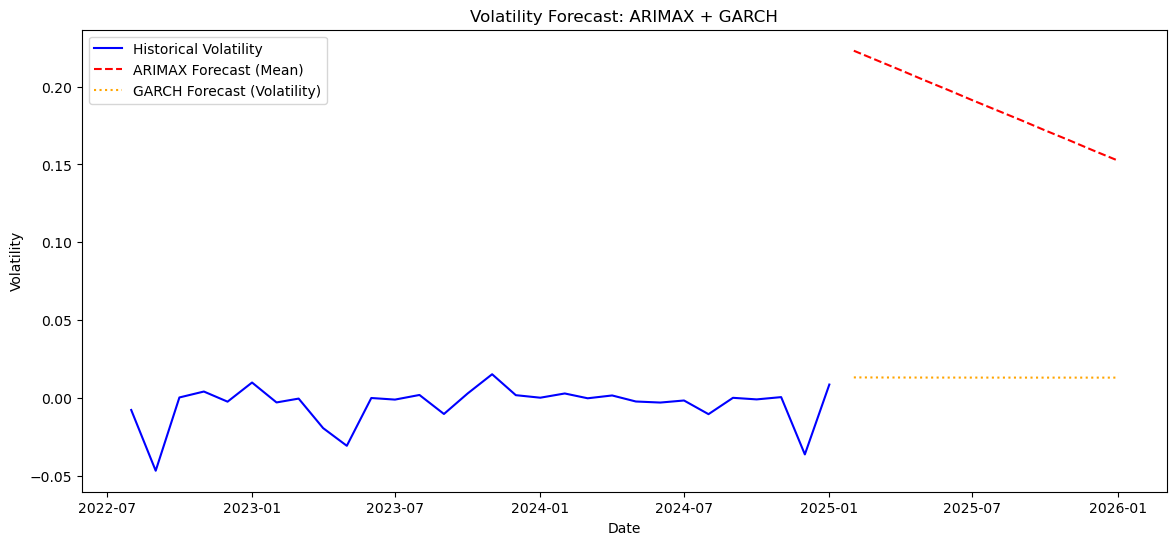

In [43]:

# Target variable
volatility = df['Volatility']

# First difference to make stationary
vol_diff = volatility.diff().dropna()

# Exogenous variables
exog_vars = df[['CPI', 'Bond_Yield', 'EURUSD', 'ZEW_Sentiment', 'Unemployment', 'GDP']]
exog_vars = exog_vars.loc[vol_diff.index]  # align with vol_diff

# --- Step 1: Fit ARIMAX ---
# Example ARIMA order (p,d,q)
arimax_model = ARIMA(vol_diff, order=(1,0,1), exog=exog_vars)
arimax_result = arimax_model.fit()

# --- Step 2: Forecast next 12 months (ARIMAX) ---
# Simple method: repeat last known exogenous values
future_exog = exog_vars.tail(1).values.repeat(12, axis=0)
arimax_forecast_diff = arimax_result.forecast(steps=12, exog=future_exog)

# Convert differenced forecast back to original scale
last_vol = volatility.iloc[-1]
arimax_forecast = last_vol + arimax_forecast_diff.cumsum()

# Create future dates for plotting
last_date = vol_diff.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
arimax_forecast.index = future_dates

# --- Step 3: Fit GARCH ---
garch_model = arch_model(vol_diff, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Forecast next 12 months volatility (standard deviation)
garch_forecast = garch_result.forecast(horizon=12)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1, :])
garch_volatility = pd.Series(garch_volatility, index=future_dates)

# --- Step 4: Plot results ---
plt.figure(figsize=(14,6))
plt.plot(vol_diff, label='Historical Volatility', color='blue')
plt.plot(arimax_forecast, label='ARIMAX Forecast (Mean)', color='red', linestyle='--')
plt.plot(garch_volatility, label='GARCH Forecast (Volatility)', color='orange', linestyle=':')
plt.title('Volatility Forecast: ARIMAX + GARCH')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [44]:
print(arimax_result.summary())


                               SARIMAX Results                                
Dep. Variable:             Volatility   No. Observations:                   30
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 100.091
Date:                Sat, 06 Sep 2025   AIC                           -180.182
Time:                        21:15:47   BIC                           -166.170
Sample:                    08-01-2022   HQIC                          -175.699
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7237      0.177      4.085      0.000       0.376       1.071
CPI              -0.0088      0.002     -4.548      0.000      -0.013      -0.005
Bond_Yield        0.0182      0.012     

# After Standardising

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
exog_scaled = pd.DataFrame(scaler.fit_transform(exog_vars), columns=exog_vars.columns, index=exog_vars.index)

# Fit ARIMAX with scaled exogenous variables
arimax_model = ARIMA(vol_diff, order=(1,0,1), exog=exog_scaled)
arimax_result = arimax_model.fit()
print(arimax_result.summary())


                               SARIMAX Results                                
Dep. Variable:             Volatility   No. Observations:                   30
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 100.720
Date:                Sat, 06 Sep 2025   AIC                           -181.439
Time:                        21:16:11   BIC                           -167.427
Sample:                    08-01-2022   HQIC                          -176.957
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0047      0.001     -4.664      0.000      -0.007      -0.003
CPI              -0.0228      0.005     -4.230      0.000      -0.033      -0.012
Bond_Yield        0.0063      0.005     

C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vishw\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
